### Notebook containing EDA results of the <> Dataset
- MBA All Trans
- MBA All Returns

In [1]:
import pandas as pd
import sys, os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

''' setup paths '''
data_dir = '../data/'

In [2]:
for doc in os.listdir(data_dir):
    if doc.endswith('csv'):
        df_0911 = pd.read_csv(os.path.join(data_dir,doc),index_col=0)
df_0911.head()

/Users/areichel/opt/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
print df_0911.describe()

           Quantity         Price    Customer ID
count  1.067371e+06  1.067371e+06  824364.000000
mean   9.938898e+00  4.649388e+00   15324.638504
std    1.727058e+02  1.235531e+02    1697.464450
min   -8.099500e+04 -5.359436e+04   12346.000000
25%    1.000000e+00  1.250000e+00   13975.000000
50%    3.000000e+00  2.100000e+00   15255.000000
75%    1.000000e+01  4.150000e+00   16797.000000
max    8.099500e+04  3.897000e+04   18287.000000


In [85]:
def cleanup_df(df_in):
    ''' clean up DESCRIPTION col of df_in to:
            1. remove spaces
            2. drop rows w/o invoice numbers
            3. drop postage row
            4. remove returned transactions (C) '''
    # drop extra spaces
    df_in.loc[:,'Description'] = df_in.loc[:,'Description'].str.strip()
    # drop rows w/o invoice number
    #df_in.dropna(axis=0, subset=['Invoice'], inplace=True)
    df_in.loc[:,'Invoice'] = df_in.loc[:,'Invoice'].astype(str)
    # drop postage row
    #df_in = df_in.Description.drop('POSTAGE', axis = 0)
    # drop Invoice == 'C' rows
    df_in = df_in[~df_in.loc[:,'Invoice'].str.contains('C')]
    
    return df_in

def encode_purch(item):
    ''' set all instances of purchase to 1, else == 0
        drop postage column '''
    if item >= 1:
        return 1
    else:
        return 0

def make_basket(df_in):
    ''' setup basket for MBA 
            1. One Hot Encode transactions 
            2. '''
    df_cleaned = cleanup_df(df_in)
    basket = (df_cleaned.groupby(['Invoice','Description'])['Quantity']
              .sum().unstack().reset_index().fillna(0).set_index('Invoice'))
    
    basket = basket.applymap(encode_purch)
    #print basket.POSTAGE
    if 'POSTAGE' in basket.columns:
        basket = basket.drop('POSTAGE', axis = 1)
    return basket

In [86]:
def mine_rules(country, min_supp = 'NA', verbose = False):  
    ''' function to extract rules or perform min_supp sensitivity test if no
        min_supp is provided '''
    # find orders by country
    df_country = df_0911[df_0911.Country == country]
    
    # make baskets
    baskets = make_basket(df_country)
    
    ''' if min_supp not given, run sensitivity test on minsupp, else find
        all association rules '''
    if min_supp == 'NA':
        items = {}
        for min_sup in np.linspace(0.41, 0.06, 35):
            frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
            items[min_sup] = len(frq_itms)
            if verbose == True:
                print "Considering Min_Supp: {}: {}".format(min_sup, len(frq_itms))
        freq_items = pd.DataFrame.from_dict(items, orient='index')
        return items
    else:
        freq_items = apriori(baskets, min_support=min_supp, use_colnames=True)
        rules = association_rules(freq_items, metric='lift', min_threshold=1)
        return rules


### Grab only US orders, to start

In [22]:
df_USorders = df_0911[df_0911.Country == 'USA']
print "US Orders: ", len(df_USorders.Invoice.unique())
df_USorders.head()

US Orders:  25


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.0,USA
51589,494110,21268,VINTAGE BLUE TINSEL REEL,24,2010-01-11 12:29:00,2.10,12549.0,USA
51590,494110,21412,VINTAGE GOLD TINSEL REEL,11,2010-01-11 12:29:00,0.42,12549.0,USA
51591,494110,22083,PAPER CHAIN KIT RETRO SPOT,6,2010-01-11 12:29:00,2.95,12549.0,USA
51592,494110,22084,PAPER CHAIN KIT EMPIRE,6,2010-01-11 12:29:00,2.95,12549.0,USA


In [23]:
print make_basket(df_USorders).shape
baskets = make_basket(df_USorders)
baskets.head()

(20, 303)


Description,12 PENCILS SMALL TUBE RED RETROSPOT,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES SPACEBOY DESIGN,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,60 CAKE CASES DOLLY GIRL DESIGN,...,VINTAGE UNION JACK BUNTING,VINTAGE UNION JACK SHOPPING BAG,WOOD STAMP SET BEST WISHES,WOODLAND DESIGN COTTON TOTE BAG,WRAP CHRISTMAS VILLAGE,WRAP COWBOYS,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP I LOVE LONDON,WRAP WEDDING DAY
Invoice,,,,,,,,,,,,,,,,,,,,,
489444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494891,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


In [87]:
items = {}
for min_sup in np.linspace(0.41, 0.06, 35):
    print "Considering Min_Supp: ", min_sup
    frq_itms = apriori(baskets, min_support=min_sup, use_colnames=True)
    items[min_sup] = len(frq_itms)

Considering Min_Supp:  0.41
Considering Min_Supp:  0.39970588235294113
Considering Min_Supp:  0.38941176470588235
Considering Min_Supp:  0.3791176470588235
Considering Min_Supp:  0.36882352941176466
Considering Min_Supp:  0.3585294117647059
Considering Min_Supp:  0.34823529411764703
Considering Min_Supp:  0.3379411764705882
Considering Min_Supp:  0.3276470588235294
Considering Min_Supp:  0.31735294117647056
Considering Min_Supp:  0.3070588235294117
Considering Min_Supp:  0.29676470588235293
Considering Min_Supp:  0.2864705882352941
Considering Min_Supp:  0.27617647058823525
Considering Min_Supp:  0.26588235294117646
Considering Min_Supp:  0.2555882352941176
Considering Min_Supp:  0.2452941176470588
Considering Min_Supp:  0.235
Considering Min_Supp:  0.22470588235294114
Considering Min_Supp:  0.21441176470588233
Considering Min_Supp:  0.20411764705882351
Considering Min_Supp:  0.19382352941176467
Considering Min_Supp:  0.18352941176470586
Considering Min_Supp:  0.17323529411764704
Consi

(0.42, 0.04)

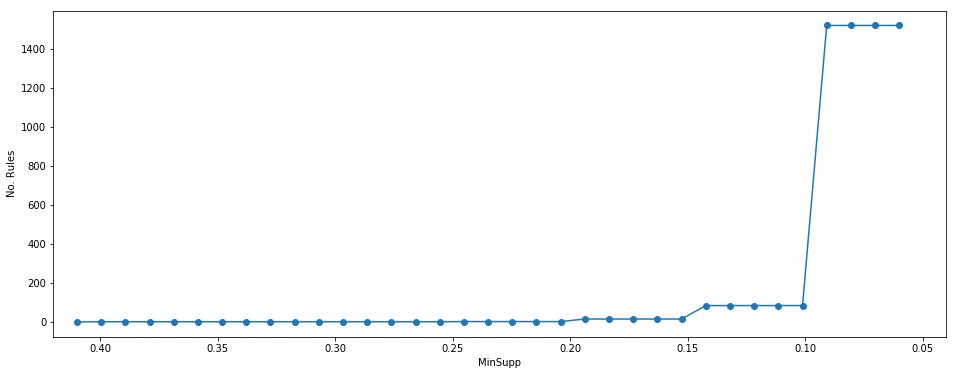

In [88]:
freq_items = pd.DataFrame.from_dict(items, orient='index')

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.set_xlabel('MinSupp')
ax.set_ylabel('No. Rules')
ax.scatter(freq_items.index, freq_items.iloc[:,0])
ax.plot(freq_items.sort_index())
ax.set_xlim(0.42, 0.04)

In [26]:
rules = association_rules(frq_itms, metric='lift', min_threshold= 1)
rules.shape

(36950, 9)

In [27]:
mine_rules(country = 'USA', min_supp = 0.06).shape

(36950, 9)

### Find ideal min_supp, by country

In [93]:
print "Unique Countries in Data: {}".format(len(df_0911.Country.unique()))

Unique Countries in Data: 43


In [95]:
df_0911.shape

(1067371, 8)

In [96]:
df_0911[df_0911.Country == 'Japan'].shape

(582, 8)

In [ ]:
rules_cnt_dict = {}
for locale in df_0911.Country.unique():
    if locale not in ['Japan','United Kingdom']:
        print locale
        #rules_cnt = mine_rules(locale)
        rules_cnt_dict[locale] = mine_rules(locale)

France
USA
Belgium
Australia
EIRE
Germany
Portugal
Denmark
Nigeria


In [92]:
pd.DataFrame.from_dict(rules_cnt_dict)

,Australia,Belgium,Denmark,EIRE,France,Germany,Portugal,USA
0.060000,72,106,218,24,58,32,189,1519
0.070294,33,57,81,14,44,21,107,1519
0.080588,19,35,81,10,34,16,68,1519
0.090882,15,30,81,8,25,11,39,1519
0.101176,5,21,31,7,18,9,25,84
0.111471,3,17,31,5,14,8,19,84
0.121765,2,12,15,5,11,6,13,84
0.132059,1,10,15,3,6,6,13,84
0.142353,0,9,8,2,5,3,10,84
0.152647,0,7,8,2,4,3,9,15


### Loop through 3 countries, finding rules

In [54]:
rules = {}
rules_path = os.path.join(os.getcwd(),'../rules/')
for locale in df_0911.Country.unique()[:1]:
    if locale != 'United Kingdom':
        print locale
        file_name = '{}_rules.csv'.format(locale)
        rules = mine_rules(locale, min_supp=0.06).sort_values('confidence', ascending=False)
        rules[locale] = rules

        print "Writing {} rules to {}".format(locale,os.path.join(rules_path,file_name))
        rules.to_csv(os.path.join(rules_path,file_name))

In [55]:
rules

{}